In [ ]:
!pip install pyspellchecke

ERROR: Could not find a version that satisfies the requirement pyspellchecke (from versions: none)
ERROR: No matching distribution found for pyspellchecke


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/classification_coding_open_ended_occupational_responses_ENAHO/data/interim/enaho_merged.parquet'
# ruta = r'D:\CURSOS\CURSO INEI\PEU CD INEI\Proyecto Integrador\Data\enaho_merged.parquet'
df = pd.read_parquet(ruta,engine='pyarrow')
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438428 entries, 0 to 438427
Data columns (total 37 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   anio          438428 non-null  object 
 1   conglome      438428 non-null  object 
 2   vivienda      438428 non-null  object 
 3   hogar         438428 non-null  object 
 4   codperso      438428 non-null  object 
 5   txt505        438428 non-null  object 
 6   txt505b       438428 non-null  object 
 7   p208a         438428 non-null  int8   
 8   p501          437795 non-null  float64
 9   p502          154175 non-null  float64
 10  p503          150123 non-null  float64
 11  p504          148143 non-null  float64
 12  p5041         148143 non-null  float64
 13  p5042         148143 non-null  float64
 14  p5043         148143 non-null  float64
 15  p5044         148143 non-null  float64
 16  p5045         148143 non-null  float64
 17  p5046         148143 n

In [ ]:
# Verificando valores peridos
df.isna().sum()*100/df.shape[0]

,0
anio,0.000000
conglome,0.000000
vivienda,0.000000
hogar,0.000000
codperso,0.000000
txt505,0.000000
txt505b,0.000000
p208a,0.000000
p501,0.144379
p502,64.834591


¿Cuáles son las variables añadidas durante el merge?
- p301a1

¿Cuáles son las variables a analizar?
- txt505 - literales de ocupación
- txt505b - tareas de su ocupación
- p505r4 - codificación ocupación cno-2015
- p506r4 - codificación actividad cno-2015
- p207 - sexo
- p208a - Edad
- p301a - Grado de estudios
- p507 - Posición ocupacional
- p510 - Organización para el que labora
- p301a1 - Carrera superior universitaria o no universitaria

In [ ]:
# Filtrando solo empleados, ya que solo estos son considerados en la p505
df = df[
    (df['p501'] == 1) |
    (df['p502'] == 1) |
    (df['p503'] == 1) |
    (df['p5041'] == 1) |
    (df['p5042'] == 1) |
    (df['p5043'] == 1) |
    (df['p5044'] == 1) |
    (df['p5045'] == 1) |
    (df['p5046'] == 1) |
    (df['p5047'] == 1) |
    (df['p5048'] == 1) |
    (df['p5049'] == 1) |
    (df['p50410'] == 1) |
    (df['p50411'] == 1)
]
df.shape

(316025, 37)

Resumen breve general

In [ ]:
variables = [
    'txt505',
    'txt505b',
    'p208a',
    'p207',
    'p301a',
    'p506r4',
    'p507',
    'p510',
    'p505r4',
    'p207_label',
    'p301a_label',
    'p506r4_label',
    'p507_label',
    'p510_label',
    'p505r4_label',
    'p301a1',
    'p301a1_label'
]

In [ ]:
# Convertir en NA a las celdas vacias
df.loc[df['txt505'].str.strip() == '', 'txt505'] = np.nan
df.loc[df['txt505b'].str.strip() == '', 'txt505b'] = np.nan

In [ ]:
# dataframe solo con variables de interes
df=df[variables]

In [ ]:
# Valores perdidos
df.isna().sum()*100/df.shape[0]

,0
txt505,0.000000
txt505b,0.135116
p208a,0.000000
p207,0.000000
p301a,0.024998
p506r4,0.000000
p507,0.000000
p510,62.358991
p505r4,0.000000
p207_label,0.000000


- La mayor cantidad de valores perdidos se encuentran en las variables de organización en la que labora y la carrera de los que estudian superior universitaria o no universitaria

# 1. EDA Univariado

## 1.1 txt505 - literales de ocupación

In [ ]:
# Verificar valores perdidos, vacios o duplicados
print('Texto perdido')
print(df['txt505'].isna().sum())

print('Texo vacio')
print((df['txt505'].str.strip() == '').sum())

print('Texto minuscula')
print(df['txt505'].str.islower().sum())

Texto perdido
0
Texo vacio
0
Texto minuscula
0


- Todos los literales se recopilan en mayúsculas, no sé si este uso de mayúsculas tiene injerencia en la forma de la vectorización

In [ ]:
from collections import Counter
contador = Counter()

# Itera sobre cada texto, sin crear grandes listas
for texto in df['txt505'].dropna():
    contador.update(texto.split())

# Métricas principales
n_total_palabras = sum(contador.values())
vocabulario_total = list(contador.elements())
vocabulario_unico = set(contador.keys())
n_vocabulario_unico = len(vocabulario_unico)

print(f"Número total de palabras: {n_total_palabras:,}")
print(f"Vocabulario único: {n_vocabulario_unico:,}")


Número total de palabras: 997,288
Vocabulario único: 16,206


- Existe un vocabulario único de 16,206 palabras

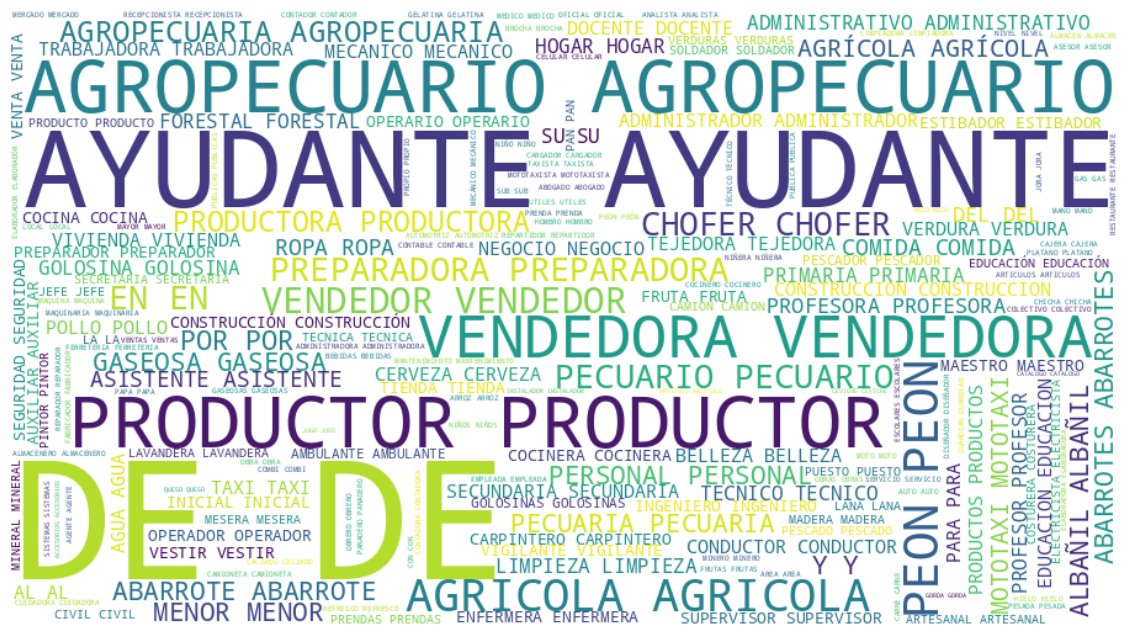

In [ ]:
# Nube de palabras de el vocabulario total
from wordcloud import WordCloud
texto_1p = ' '.join(vocabulario_total)
wordcloud = WordCloud(width=900, height=500, background_color='white', colormap='viridis').generate(texto_1p)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/tmp/ipython-input-924461062.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')


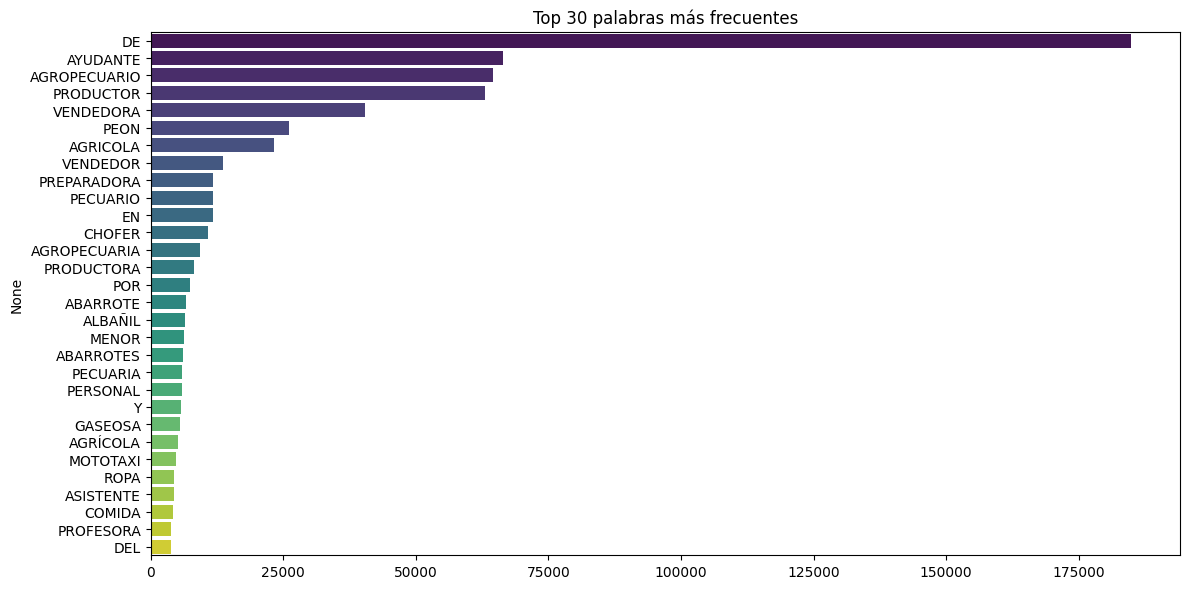

In [ ]:
# Frecuencia de palabras del vocabulario total
serie_palabras = pd.Series(vocabulario_total)
frecuencias = serie_palabras.value_counts()[:30]

plt.figure(figsize=(12,6))
sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')
plt.title('Top 30 palabras más frecuentes')
plt.tight_layout()
plt.show()

- Existe una presencia importante de palabras sin significado como (de, en, por, y, del)
- Existen palabras como (vendedor,productor) y (vendedora,productora), que significan.

/tmp/ipython-input-3005202595.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')


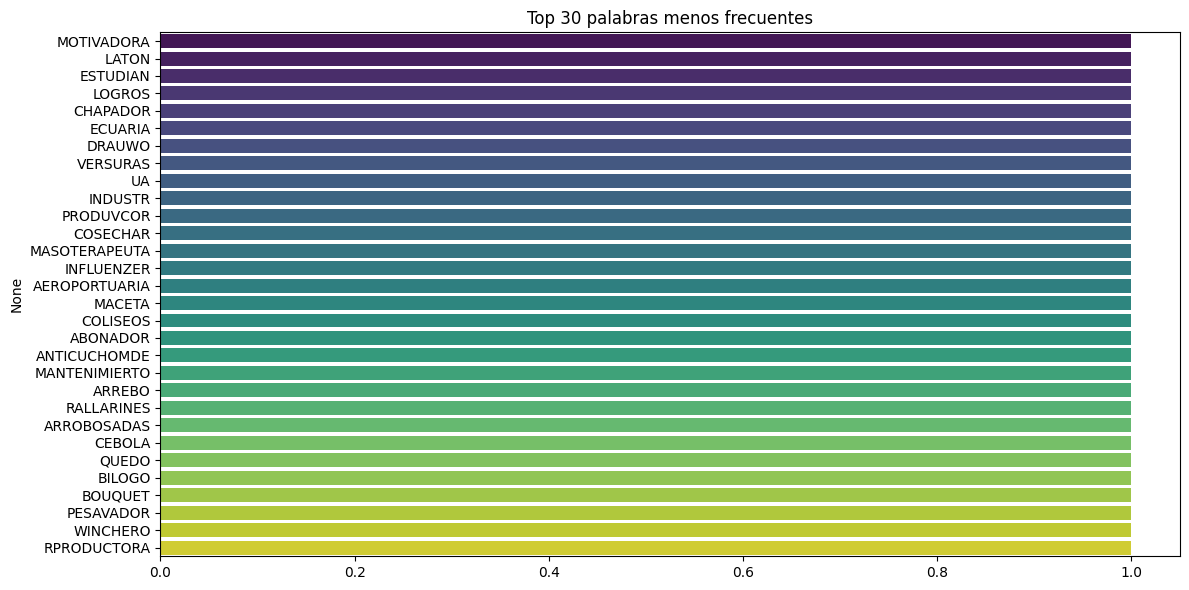

In [ ]:
# Frecuencia de palabras del vocabulario total
serie_palabras = pd.Series(vocabulario_total)
frecuencias = serie_palabras.value_counts()[-30:]

plt.figure(figsize=(12,6))
sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')
plt.title('Top 30 palabras menos frecuentes')
plt.tight_layout()
plt.show()

- Problema: Las palabras menos frecuentes usualmente son aquellas que estan mal escritas.

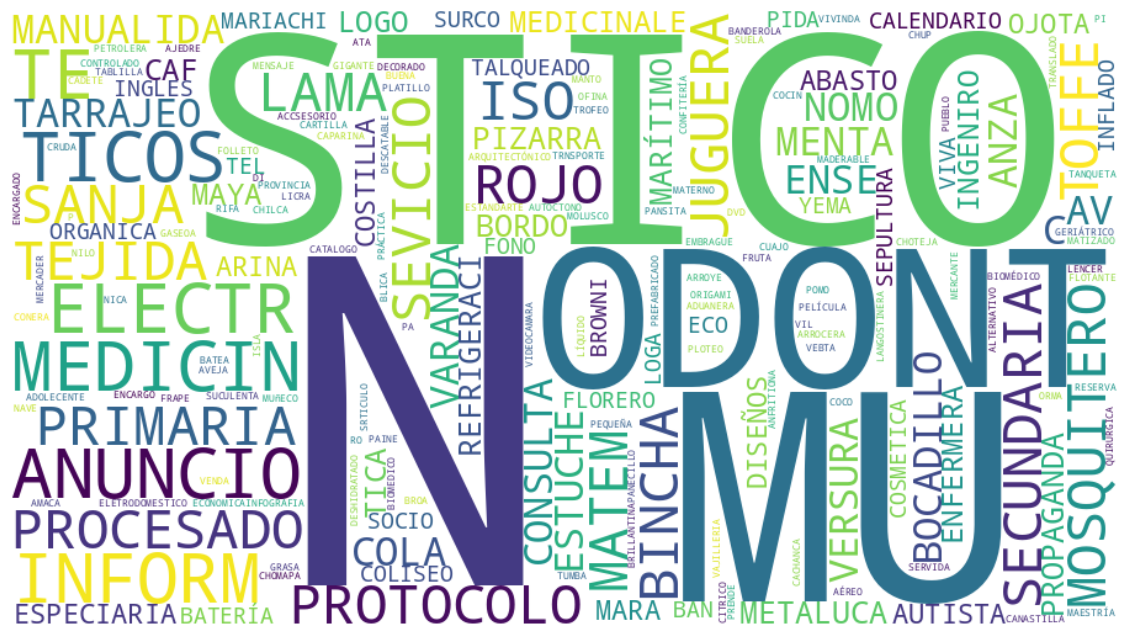

In [ ]:
# Verificando palabras de una sola aparición
from wordcloud import WordCloud
serie_palabras = pd.Series(vocabulario_total)
frecuencias = serie_palabras.value_counts()
palabras_unicas = frecuencias[frecuencias == 1].index.tolist()

texto_1p = ' '.join([str(p) for p in palabras_unicas if isinstance(p, str)])
wordcloud = WordCloud(width=900, height=500, background_color='white', colormap='viridis').generate(texto_1p)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- Problemas: en corcondancia con las palabras menos frecuentes, esto refuerza nuevamente la existencia de palabras mal escritas.

In [ ]:
# Longitud promedio de los textos (en palabras o caracteres).
print('N° palabras promedio:',
      df['txt505'].dropna().str.split().apply(len).mean())

print('N° caracteres promedio:',
      df['txt505'].dropna().str.len().mean())

N° palabras promedio: 3.1557250217546082
N° caracteres promedio: 23.784786013764734


- Los literales presentan un promedio de tres palabras, lo que sugiere una tendencia a respuestas muy breves con poco contenido informativo.

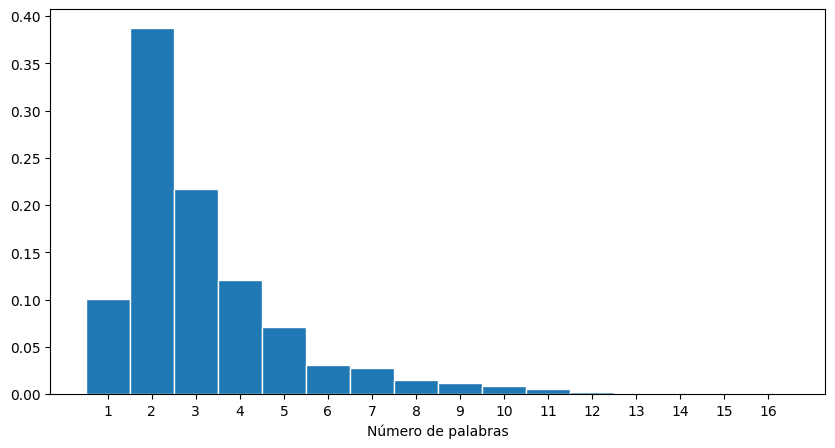

In [ ]:
# Distribución de longitudes de literales en base a palabras.
df['n_palabras_txt505'] = df['txt505'].str.split().apply(len)

plt.figure(figsize=(10,5))
plt.hist(df['n_palabras_txt505'],
         bins=np.arange(df['n_palabras_txt505'].min(), df['n_palabras_txt505'].max() + 2) - 0.5,
         edgecolor='white',
         density=True)
plt.xlabel('Número de palabras')
plt.xticks(range(1, 17))
plt.show()

- Más del 80% de los literales presentan menor o igual a 4 palabras

/tmp/ipython-input-789660185.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')


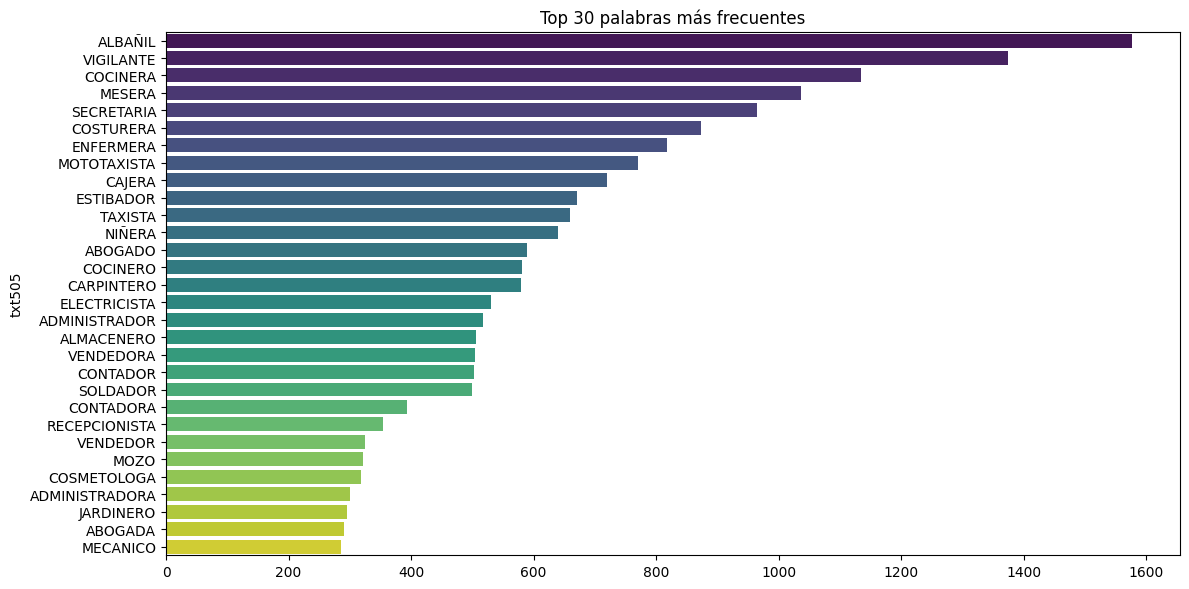

In [ ]:
# Literales con palabras unicas
serie_palabras = pd.Series(vocabulario_total)
frecuencias = df['txt505'][df['n_palabras_txt505']==1].value_counts()[:30]

plt.figure(figsize=(12,6))
sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')
plt.title('Top 30 palabras más frecuentes')
plt.tight_layout()
plt.show()

- La mayoria de los literales que presentan una palabra son descripciónes de profesiones o oficios directamente

In [ ]:
# Distribución de longitudes de literales en base a caracteres.
df['n_caracter_txt505'] = df['txt505'].dropna().str.len()
df['n_caracter_txt505'].describe()

,n_caracter_txt505
count,316025.000000
mean,23.784786
std,11.830971
min,1.000000
25%,17.000000
50%,21.000000
75%,30.000000
max,70.000000


- Existen literales de que contienen solo un caracter, lo cual parece sospechoso usualmente no existen palabras con un solo carácter

In [ ]:
# Literales que contienen numeros
print(df['txt505'][df['txt505'].str.contains(r'\d+', na=False)].shape[0])
df['txt505'][df['txt505'].str.contains(r'\d+', na=False)]

12


,txt505
45786,PE0N AGROPECUARIO
70076,CONDUCT0R DE TRICICLO
105399,ELABORADOR DE MAQUETA VIRTUAL EN 3D
150843,SUB OFICIAL DE 3RA
170854,5
173358,4
178994,ASESOR DE ESTUDIENTES PARA MANEJO DE PROGRAMAS...
227096,AUXILIAR DE 0FICINA
256906,SUB OFICIAL DE 2DA
290746,ASES0RA LEGAL


- Problema: Existen 12 registros que contienen numeros en los literales, todos excepto dos, contienen caracteres que han sido escritos en forma de numero
- Solución: Corregir

In [ ]:
# Literales que presentan solo numeros
df[~df['txt505'].str.contains(r'[a-zA-ZñÑáéíóúÁÉÍÓÚ]', na=False)][['txt505', 'txt505b', 'p506r4', 'p506r4_label']]

,txt505,txt505b,p506r4,p506r4_label
170854,5,PREPARAR DECORAR TORTA,1071.0,elaboraciÃ³n de productos de panaderÃ­a
173358,4,VENDER OFRECER COBRAR ATENDER,4782.0,"venta al por menor de productos textiles, pren..."


- Problema: 2 registros con solo números

- Solución: Filtrar o tomar rol de especialista y asignar el común denominador de la ocupación que contiene el mismo código

In [ ]:
# Literales con 2 caracteres o menos que no incluya los anteriores revisados

df[
    df['txt505'].str.contains(r'[a-zA-ZñÑáéíóúÁÉÍÓÚ]', na=False) &
    (df['txt505'].str.len() <= 2)
][['txt505','txt505b','p506r4_label']]

,txt505,txt505b,p506r4_label
23439,DJ,ARMAR EQUIPO PONER MEZCLAR MÚSICA,"actividades de arte, entretenimiento y creativ..."
56436,DJ,HACER MEZCLA DE MUSICA ANIMAR,"actividades de arte, entretenimiento y creativ..."
216186,DJ,PROGRAMAR MÚSICA EN UNA EN UNA FIESTA SOCIAL C...,"actividades de arte, entretenimiento y creativ..."
248091,DJ,CLASIFICAR DISCO PONER MUSICA EN DISCOTECA,otras actividades de diversiÃ³n y esparcimient...
257102,DJ,MESCLAR MUSICA PONER MUSICA,otras actividades de diversiÃ³n y esparcimient...
273432,DJ,AYUDAR ACOMODAR EQUIPOS MEZCLAR MUSICA,otras actividades de diversiÃ³n y esparcimient...
301036,DJ,PROGRAMAR LA MUSICA DE LA DISCOTECA,otras actividades de diversiÃ³n y esparcimient...
310719,DJ,REALIZAR MEZCLA DE MUSICA,"actividades de arte, entretenimiento y creativ..."
323796,DJ,PONER MUSIC,otras actividades de diversiÃ³n y esparcimient...
326037,DJ,PONER MUSICA EQUALIZAR SONIDA,"actividades de arte, entretenimiento y creativ..."


- Problema: A simple vista estos caracteres parecen mostrar error, sin embargo  por la descripción de las actividades se aprecia que todos querían decir "DJ" (Disc Jockey)

- Solución: La palabra DJ es un peruanismo que si brinda información, esto no denota un error, en el caso de DG debe de cambiarse a DJ o Disc Jockey para homogenizar, ya que se refieren a los mismo.

In [ ]:
# Literales con 3 caracteres o menos que no incluya los anteriores revisados

df[
    df['txt505'].str.contains(r'[a-zA-ZñÑáéíóúÁÉÍÓÚ]', na=False) &
    (df['txt505'].str.len() <= 3) &
    (~df['txt505'].isin(['DJ', 'DG']))
][['txt505', 'txt505b', 'p506r4_label']]

,txt505,txt505b,p506r4_label
339883,SUP,PAGAR PERSONAL PROVEEDORES ADMINISTRAR NEGOCIO,actividades de arquitectura e ingenierÃ­a y actividades conexas de asesoramiento tÃ©cnico


- Problema: 1 solo registro con la palabra "SUP", la cual no guarda sentido ni con su Actividad Económica ni con sus funciones.
- Solución: Debe filtrarse del cleaning.

In [ ]:
# Literales con 4 caracteres o menos que no incluya los anteriores revisados
df[
    df['txt505'].str.contains(r'[a-zA-ZñÑáéíóúÁÉÍÓÚ]', na=False) &
    (df['txt505'].str.len() <= 4) &
    (~df['txt505'].isin(['DJ', 'DG', 'SUP']))
][['txt505', 'txt505b','p506r4_label']].drop_duplicates(subset='txt505').reset_index(drop=True)

,txt505,txt505b,p506r4_label
0,CHEF,PREPARAR INGREDIENTES PELAR PICAR COCINAR,restaurantes y servicios mÃ³viles de alimentaciÃ³n
1,MOZA,ATENDER MESAS,otras actividades de diversiÃ³n y esparcimiento n.c.p.
2,MOZO,ATENDER OFRECER CLIENTE LLEVAR PLATOS,restaurantes y servicios mÃ³viles de alimentaciÃ³n
3,PEON,LIMPIAR CANALES SACAR BASURA,actividades de apoyo a los cultivos
4,TAXI,CONDUCIR,otros tipos de transporte terrestre de pasajeros
5,MOSA,ATENDER CLIENTE PREPARAR REFRESCO LIMPIAR LOCAL,restaurantes y servicios mÃ³viles de alimentaciÃ³n
6,JUEZ,LLEVAR ACABO JUCIOS AUDIENCIAS,actividades de mantenimiento del orden pÃºblico y de seguridad
7,BUZO,EXTRAER PESCADO DEL MAR,pesca marÃ­tima
8,JEFE,GESTIONAR TRAMITAR DIRIGIR,actividades de la administraciÃ³n pÃºblica en general
9,MOSO,MOSEAR TOMAR ENTREGAR PEDIDOS,restaurantes y servicios mÃ³viles de alimentaciÃ³n


Todos los registros de ocupación tienen sentido (comparando con su actividad económica).
- Problema:  Existen hay errores ortográficos y/o tipográficos. En vez de MOZO o MOZA, escribieron 'MOSO', 'MOSA', 'MOZQ' (Este caso especial exactamente en vez de MOZA). También hay uno que dice PEON en vez de PEÓN.

- Solución: Corregir con un LLM u otras estrategias

In [ ]:
# Observacion de literales con carácteres largos

pd.set_option('display.max_colwidth', None)
df['txt505'][df['n_caracter_txt505']>60]

,txt505
40,PREPARADORA VENDEDORA DE COMIDA GOLOSINA GASEOSA AGUA MINERAL POR MENO
41,AYUDANTE DE PREPARADORA VENDEDORA DE COMIDA GOLOSINA GASEOSA POR MENOR
42,VENDEDORA DE ABARROTE FRUTA PAN PAPA CERVEZA GASEOSA POR MENOR
104,PREPARADOR DE GELATINA VENDEDOR DE GOLOSINA AGUA MINERAL GASEOSA POR M
105,AYUDANTE DE PREPARADOR DE GELATINA VENDEDOR DE GOLOSINA POR MENOR
...,...
438141,AYUDANTE DE PREPARADORA VENDEDORA DE PARA ARREBOSADA RALLARINES ARREBO
438155,PREPARADORA VENDEDORA DE ANTICUCHO DE CORAZON DE RES DE MOLLEJA Y DE P
438156,AYUDANTE DE PREPARADORA VENDEDORA DE ANTICUCHOMDE CORAZON DE RES DE MO
438309,VENDEDORA DE ABARROTE GASEOSA GOLOSINA CARBON PREPARADORA VENDEDORA DE


- Existen literales bastante detallados que contienen palabras mal escritas

Posibles errores encontrados: 11972


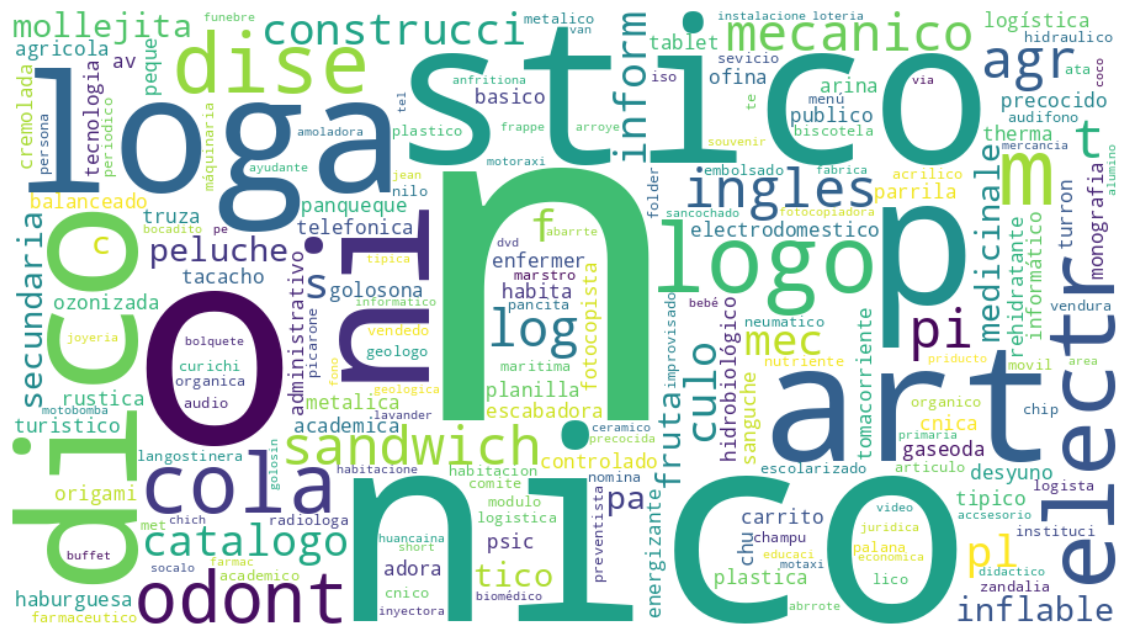

In [ ]:
# Análisis de palabras mal escritas encontradas en el vocabulario unico

from spellchecker import SpellChecker

# Crear corrector para español
spell = SpellChecker(language='es')
errores = spell.unknown(vocabulario_unico)

print(f"Posibles errores encontrados: {len(errores)}")

texto_1p = ' '.join([str(p) for p in list(errores) if isinstance(p, str)])
wordcloud = WordCloud(width=900, height=500, background_color='white', colormap='viridis').generate(texto_1p)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- De acuerdo a este identificador de errores en español existen 11,972 errores. Aunque tambien identifica palabras que estan bien escritas, sugiere la necesidad de corregir palabras.

## 1.2. p505r4 - Codificación cno-2015

In [ ]:
# Valores perdidos
df['p505r4'].isna().sum()

np.int64(0)

In [ ]:
# Cantidad de categorias unicas
print(df['p505r4'].nunique())

450


In [ ]:
# Verificación de codigos a 4 digitos
df[['p505r4','txt505','p505r4_label']][df['p505r4'].astype(int).astype(str).str.len() < 4]

,p505r4,txt505,p505r4_label
31,220.0,SUB OFICIAL DE TERCERA,suboficiales de la policÃ­a nacional
176,120.0,OFICIAL DE LA POLICIA,oficiales de la fuerzas policiales
262,220.0,SUB OFICIAL DE PRIMERA,suboficiales de la policÃ­a nacional
327,220.0,SUB OFICIAL DE TERCERA,suboficiales de la policÃ­a nacional
1783,220.0,SUB OFICIAL DE PRIMERA,suboficiales de la policÃ­a nacional
...,...,...,...
437176,212.0,SUB OFICIAL DE LA MARINA,suboficiales de la marina de guerra
437796,220.0,SUB OFICIAL,suboficiales de la policÃ­a nacional
438008,220.0,SUB OFICIAL DE TERCERA,suboficiales de la policÃ­a nacional
438165,220.0,SUB OFICIAL DE TERCERA,suboficiales de la policÃ­a nacional


- Problema: Se identifican códigos con menos de 4 dígitos. Esto ocurre debido a que la variable fue definida con un tipo de dato incorrecto. En consecuencia, los valores numéricos pierden los ceros a la izquierda que deberían conservarse.

- Solución: Convertir la variable al tipo cadena de texto (string) y completar con ceros a la izquierda aquellos códigos que tengan menos de 4 dígitos, garantizando así una longitud uniforme.


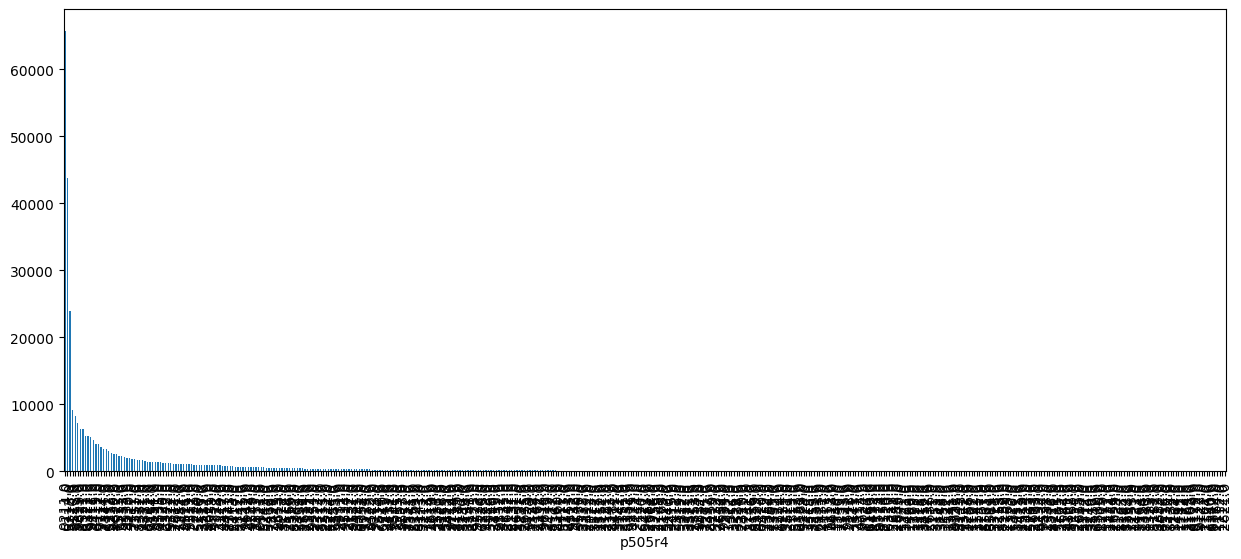

In [ ]:
# Distribución de categorias
plt.figure(figsize=(15,6))
df['p505r4'].value_counts().plot(kind='bar')
plt.show()

Problemas:
- Existencia de muchas categorías 450.
- Categorías desbalancedas

In [ ]:
# Distribución de categorías más frecuentes
cno=pd.DataFrame({'Frecuencia':df['p505r4'].value_counts(),
              'Proporción':df['p505r4'].value_counts()*100/df.shape[0]})
cno.head(10)

,Frecuencia,Proporción
p505r4,,
9211.0,65703,20.790444
6114.0,43753,13.844791
5212.0,23921,7.569338
5120.0,9101,2.879835
9313.0,8282,2.620679
5213.0,7160,2.265644
9629.0,6343,2.007120
8321.0,6265,1.982438
6121.0,5195,1.643857


- Problema: Cerca del 50% de los registros pertenecen a 10 categorías de los 450 existentes. Alta concentración en determinadas categorías.
- Pregunta: ¿Cómo balanceamos más los datos? ¿Es necesario todos los registros de estas categorías para entrenar el modelo?

In [ ]:
# Verificando categorias con menos registros
print('2 registros:',cno[cno['Frecuencia']<=2].shape[0])
print('Menos de 5 registros:',cno[cno['Frecuencia']<5].shape[0])
print('Menos de 10 registros:',cno[cno['Frecuencia']<10].shape[0])
print('Menos de 20 registros:',cno[cno['Frecuencia']<20].shape[0])

2 registros: 32
Menos de 5 registros: 55
Menos de 10 registros: 93
Menos de 20 registros: 140


- Problema: Se identificaron 32 categorías con 2 o menos registros.
- Solución: ¿Eliminar estas categorías ó crear data artificial?
- Pregunta: ¿Cuál debería ser el número mínimo de registros por categoría para garantizar un entrenamiento adecuado del modelo?


## 1.3. txt505b - Tareas

In [ ]:
# Verificar valores perdidos, vacios o duplicados
print('Texto perdido')
print(df['txt505b'].isna().sum())

print('Texo vacio')
print((df['txt505b'].str.strip() == '').sum())

print('Texto minuscula')
print(df['txt505b'].str.islower().sum())

Texto perdido
427
Texo vacio
0
Texto minuscula
0


In [ ]:
# Verificando registros con los literales perdidos
df[['txt505b','txt505','p505r4_label','p506r4_label']][df['txt505b'].isna()]

,txt505b,txt505,p505r4_label,p506r4_label
162,NaN,PEON DE ALBAÑIL,peones de la construcciÃ³n de edificios,construcciÃ³n de edificios
2137,NaN,CONDUCTOR DE VEHICULO,"conductores de automÃ³viles, taxis y camionetas",transporte terrestre de pasajeros de Ã¡reas urbanas y suburbanas
2170,NaN,COCINERO,cocineros,restaurantes y servicios mÃ³viles de alimentaciÃ³n
2172,NaN,COCINERO,cocineros,restaurantes y servicios mÃ³viles de alimentaciÃ³n
2212,NaN,CONDUCTOR DE VEHICULO,conductores de motocicletas,otros tipos de transporte terrestre de pasajeros
...,...,...,...,...
164007,NaN,PRODUCTOR AGROPECUARIO,"agricultores y trabajadores calificados de cultivos mixtos (agrÃ­colas, pecuarios y forestales)",cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
227454,NaN,PEON DE CULTIVO,peones de explotaciones agrÃ­colas y ganaderas,cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
268346,NaN,CERRAJERO,herreros y forjadores,fabricaciÃ³n de productos metÃ¡licos para uso estructural
311360,NaN,TRABAJADORA DEL HOGAR,limpiadores y asistentes domÃ©sticos,actividades de los hogares en calidad de empleadores de personal domÃ©stico


- Problema: 427 registros han sido codificados sin la existencia del literal de tareas, sugiere que solo basto el literal de ocupación y actividad para su codificación.
- Solución: Puede ser correcto imputar con espacio en blanco?

In [ ]:
from collections import Counter
contador = Counter()

# Itera sobre cada texto, sin crear grandes listas
for texto in df['txt505b'].dropna():
    contador.update(texto.split())

# Métricas principales
n_total_palabras = sum(contador.values())
vocabulario_total = list(contador.elements())
vocabulario_unico = set(contador.keys())
n_vocabulario_unico = len(vocabulario_unico)

print(f"Número total de palabras: {n_total_palabras:,}")
print(f"Vocabulario único: {n_vocabulario_unico:,}")


Número total de palabras: 1,662,691
Vocabulario único: 33,255


- Existe un incremento de palabras en el vocabulario único, esto sugiere que en el campo de descripción de tareas existe una mayor riqueza de información a comparación con el literal de ocupación

/tmp/ipython-input-924461062.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')


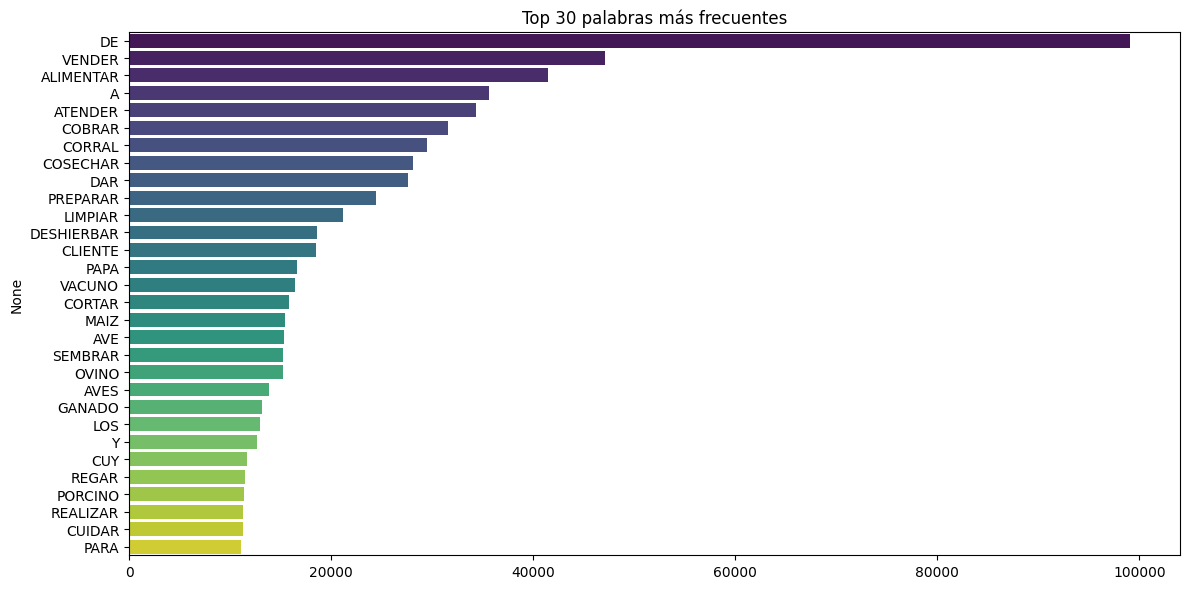

In [ ]:
# Frecuencia de palabras del vocabulario total
serie_palabras = pd.Series(vocabulario_total)
frecuencias = serie_palabras.value_counts()[:30]

plt.figure(figsize=(12,6))
sns.barplot(x=frecuencias.values, y=frecuencias.index, palette='viridis')
plt.title('Top 30 palabras más frecuentes')
plt.tight_layout()
plt.show()

- Problema: Existencia de stopwords.
- Solución: Eliminar únicamente para TF-IDF

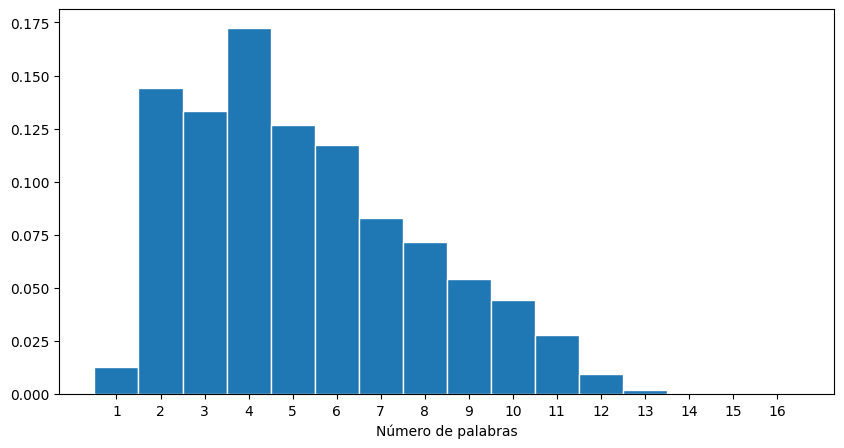

In [ ]:
# Distribución de cantidad de palabras
df['n_palabras_txt505b'] = df['txt505b'].dropna().str.split().apply(len)

plt.figure(figsize=(10,5))
plt.hist(df['n_palabras_txt505b'],
         bins=np.arange(df['n_palabras_txt505b'].min(), df['n_palabras_txt505b'].max() + 2) - 0.5,
         edgecolor='white',
         density=True)
plt.xlabel('Número de palabras')
plt.xticks(range(1, 17))
plt.show()

- Más del 80% de literales de las tareas contienen más de dos palabras

In [ ]:
# Distribución de caracteres
df['n_caracter_txt505b'] = df['txt505b'].dropna().str.len()
df['n_caracter_txt505b'].describe()

,n_caracter_txt505b
count,315598.000000
mean,36.393507
std,17.161286
min,1.000000
25%,23.000000
50%,33.000000
75%,48.000000
max,70.000000


- Sugiere problemas por la existencia de literales con 1 caracter

In [ ]:
# Literales que contienen numeros
pd.set_option('display.max_colwidth', None)
print(df['txt505b'][df['txt505b'].str.contains(r'\d+', na=False)].shape[0])
df['txt505b'][df['txt505b'].str.contains(r'\d+', na=False)]

14


,txt505b
4373,CONTROLAR EL CONSUMO DE SULFATO FERROSO EN NIÑOS ENTRE 4 A 5 AÑOS LLEN
22040,114SEMBRAR CULTIVAR LIMPIAR COSECHAR LLENAR CAJONES OFRECER VENDER COB
38087,5212VENDER ARTÍCULOS DE FERRETERÍA
44087,REP0CICIONAR PEDIDO SOLICITAR CAMBIO DE PRODUCTO MALOGRADO
83318,5120PREPARA VENDER AGUA DE MARACUYA GALLETAS JABON DETERGENTE LEJIA
86917,SEMBR4R COSECHAR DE PAPA
87167,9PASTOREAR OVINO ALIMENTAR A PORCINO AVE DE CORRAL CUYE
105399,ELABORAR MAQUETA VIRTUAL EN 3D
150301,MANTENIMIENTO Y REPARACION DE EQUIPOS GRUPOS ELECTRONEGOS Y GP9S
159796,REGISTRAR LAS MUESTRAS COVID 19 PROCESAR LOS RESALTADOS DE LAS MUESTRA


- Problema: Existen 14 registros que presentan problemas de representar carácteres con numeros
- Solución: Reemplazar por lo que corresponde

In [ ]:
# Literales que presentan solo numeros
df['txt505b'][~df['txt505b'].str.contains(r'[a-zA-ZñÑáéíóúÁÉÍÓÚ]', na=True)]

,txt505b


In [ ]:
# Literales que contienen menos o igual de 4 carácteres
pd.set_option('display.max_row', None)
print(df['txt505b'][df['n_caracter_txt505b']<=4].shape[0])
df[['txt505b','txt505','p505r4','p506r4_label']][df['n_caracter_txt505b']<=4]

62


,txt505b,txt505,p505r4,p506r4_label
5813,K,ASISTENTE ADMIISTRAVIYO,4419.0,actividades de hospitales
22016,OV,AYUDANTE AGROPECUARIA,9211.0,cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
27410,A,PEON AGRICOLA,9211.0,cultivo de uvas
40542,R,AYUDANTE AGROPECUARIO,9211.0,cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
50221,RED,PESCADOR ARTESANAL,6222.0,pesca marÃ­tima
53344,AYU,AYUDANTE DE AGROPECUARIO,9211.0,cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
55537,ALIN,AYUDANTE AGROPECUARIO,9211.0,cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
61116,MOZA,MOZA,5131.0,restaurantes y servicios mÃ³viles de alimentaciÃ³n
61130,KION,PEON ABRICOLA,9211.0,cultivo de productos agrÃ­colas en combinaciÃ³n con la crÃ­a de animales (explotaciÃ³n mixta)
64790,JJ,CHOFER DE MOTOTAXI,8321.0,otros tipos de transporte terrestre de pasajeros


- Problema: Existen literales de tareas de ocupación que en su mayoría contienen palabras sin significado o que repite lo de ocupación.
- Solución: Filtrar o recuperar lo máximo posible concatenando con la ocupación.

In [ ]:
# Identificar posibles palabras mal escritas
spell = SpellChecker(language='es')
errores = spell.unknown(vocabulario_unico)

print(f"Posibles errores encontrados: {len(errores)}")
print("Ejemplos:", list(errores)[:50])

Posibles errores encontrados: 26280
Ejemplos: ['atendel', 'pens', 'encfrado', 'licita', 'programs', 'sursir', 'piaqear', 'juveniles', 'contruye', 'confar', 'dormitorios', 'castañeris', 'realizan', 'sucir', 'fertilizando', 'forragera', 'tarnsporta', 'contracturales', 'contratas', 'amarraar', 'fala', 'estrcturas', 'anuncios', 'cronogramar', 'deshojando', 'lecturas', 'limpiera', 'situacion', 'entrregar', 'milipiar', 'espost', 'sauna', 'cuidadoras', 'elabarorar', 'cliene', 'vivieres', 'diabetico', 'irdenar', 'jóvenes', 'descarminar', 'dae', 'hidrobiológico', 'sillones', 'dañados', 'estras', 'caluficar', 'vultio', 'moles', 'alf', 'avpersonal']


- Problema: Palabras mal escritas
- Solución: Corregir palabras mal escritas

## 1.4 p506r4 - Codificación de actividades cno-2015

In [ ]:
# Verificando valores perdidos
df['p506r4'].isna().sum()

np.int64(0)

In [ ]:
# Verificando cantidad de categorias
print(df['p506r4'].nunique())

392


- Problema: La variable es un tipo de variable cadena o categorica, hay codigos con menos de 4 digitos.
- Solución: Agregar los ceros a la izquierda para obtener los 4 digitos y cambiar el tipo de variable.

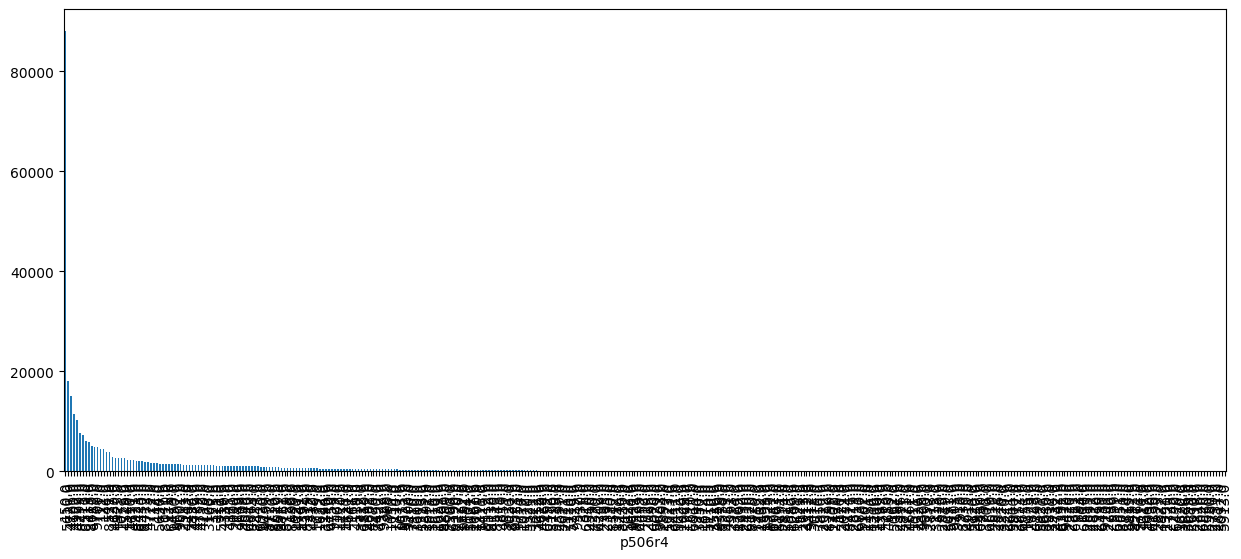

In [ ]:
# Distribución de codigos
df['p506r4'].value_counts().plot(kind='bar',figsize=(15,6))
plt.show()

- Problema: Existe muchas categorias 392 y hay un gran desbalance
- ¿Este desbalanceo sigue el mismo patron de desbalanceo que el target?

## 1.5 p207 - Sexo

In [ ]:
# Verificando valores perdidos
df['p207'].isna().sum()

np.int64(0)

In [ ]:
# Distribución de la variable
df['p207_label'].value_counts()*100/df.shape[0]

,count
p207_label,
hombre,52.342378
mujer,47.657622


## 1.6 p208a - Edad

In [ ]:
# Verificando valores perdidos
df['p208a'].isna().sum()

np.int64(0)

In [ ]:
# Distribución de edad
df['p208a'].describe()

,p208a
count,316025.000000
mean,42.472931
std,17.089421
min,14.000000
25%,29.000000
50%,42.000000
75%,55.000000
max,98.000000


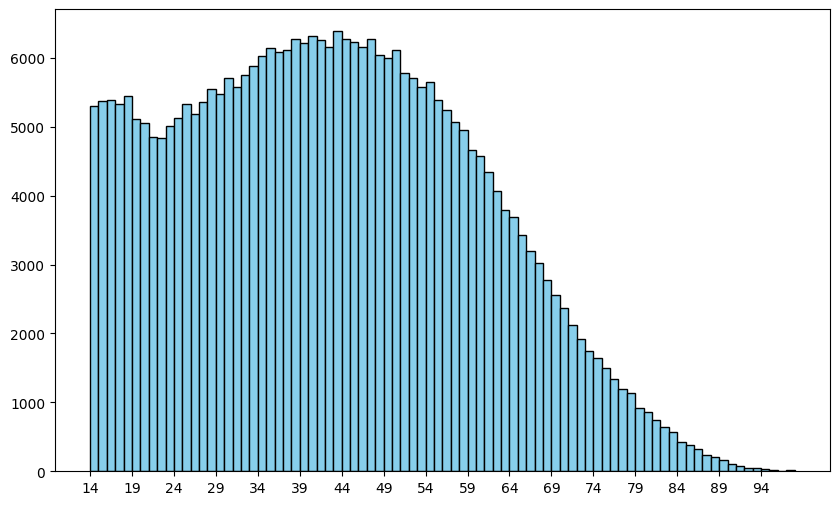

In [ ]:
# Distribución de edad
plt.figure(figsize=(10, 6))
plt.hist(df['p208a'], bins=84, color='skyblue', edgecolor='black')
plt.xticks(np.arange(df['p208a'].min(), df['p208a'].max(), 5))
plt.show()

## 1.7 p301a - Nivel o grado de estudios

In [ ]:
# Verificando valores perdidos
df['p301a'].isna().sum()

np.int64(79)

- Problema: 79 valores perdidos

In [ ]:
df[['p301a','txt505','p505r4','p207_label','p208a']][df['p301a'].isna()]

,p301a,txt505,p505r4,p207_label,p208a
10868,NaN,ESTIBADOR DE MERCADERÍA DE FERRETERÍA,9333.0,hombre,21
11209,NaN,PRODUCTOR AGROPECUARIO,6114.0,hombre,42
14220,NaN,AYUDANTE DE VENDEDOR DE ABARROTES,5212.0,mujer,36
16308,NaN,PRODUCTOR AGROPECUARIO,6114.0,hombre,46
20136,NaN,PRODUCTOR AGRICOLA,6111.0,hombre,58
21506,NaN,AYUDANTE DE VENDEDORA DE ABARROTES,5212.0,mujer,20
26587,NaN,PROFESORA DE SECUNDARIA,2330.0,mujer,27
27954,NaN,TRABAJADORA DEL HOGAR,9111.0,mujer,30
44835,NaN,ELABORADOR DE QUESO,7514.0,hombre,53
47629,NaN,SOLDADOR,7212.0,hombre,20


- Solución: Imputar puede ser en relación a edad y similitud de codigo de ocupación.

In [ ]:
# Distribución de la variable
df['p301a_label'].value_counts()

,count
p301a_label,
secundaria completa,81622
secundaria incompleta,49311
primaria incompleta,43496
primaria completa,38234
superior no universitaria completa,27038
superior universitaria completa,25520
sin nivel,15554
superior universitaria incompleta,15349
superior no universitaria incompleta,13855


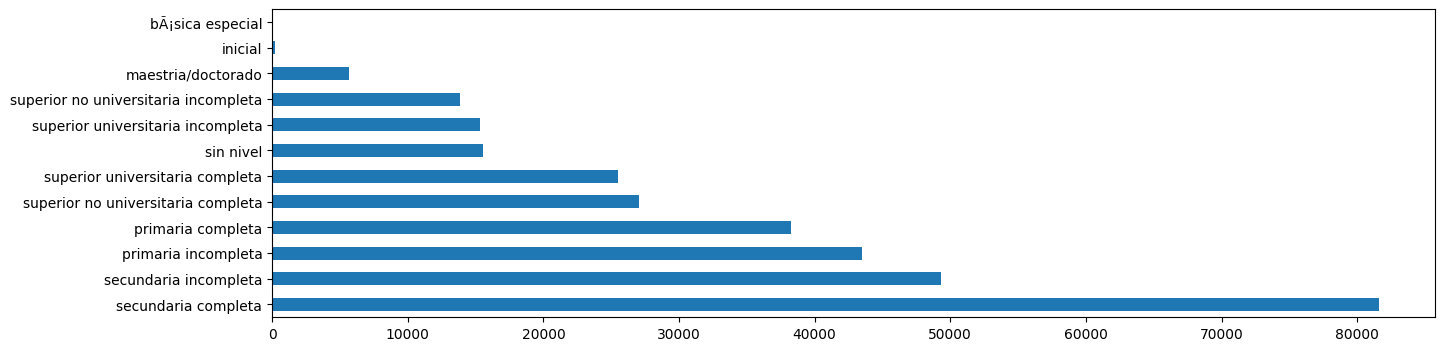

In [ ]:
# Distribución de la variable
df['p301a_label'].value_counts().plot(kind='barh',figsize=(15,4))
plt.ylabel('')
plt.show()

## 1.8 p507 - Posición ocupacional

In [ ]:
# Verificando valores perdidos
df['p507'].isna().sum()

np.int64(0)

In [ ]:
# Distribución de la variable
df['p507_label'].value_counts()*100/df.shape[0]

,count
p507_label,
trabajador independiente,38.945653
obrero,18.950716
trabajador familiar no remunerado,18.717507
empleado,18.211217
empleador o patrono,3.187090
trabajador del hogar,1.508741
otro,0.479076


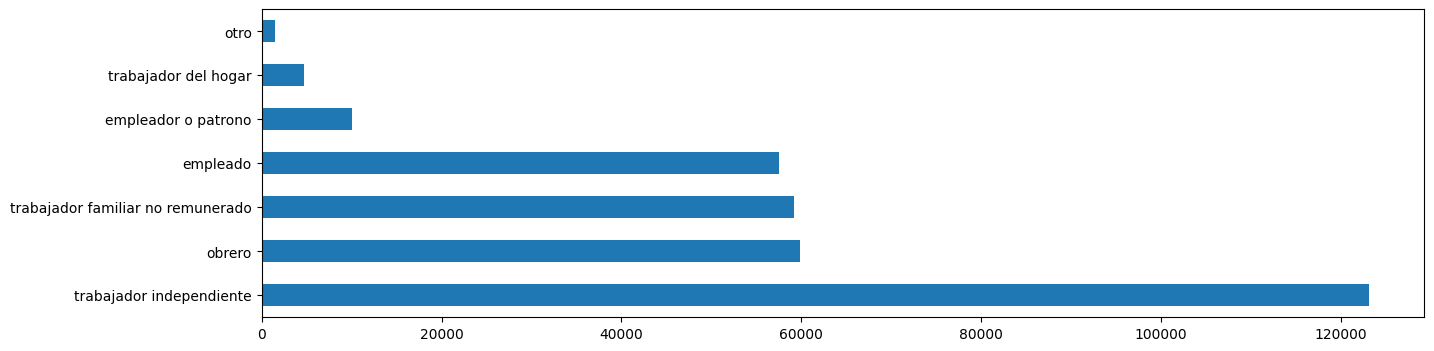

In [ ]:
# Distribución de la variable
df['p507_label'].value_counts().plot(kind='barh',figsize=(15,4))
plt.ylabel('')
plt.show()

## 1.9 p510 - Organización para el que labora

In [ ]:
# Verificando valores perdidos
print(df['p510'].isna().sum())
print(df['p510'].isna().sum()*100/df.shape[0])


197070
62.3589905861878


- Problema: Existe un 62% de valores perdidos

In [ ]:
# Distribución de la variable
df['p510_label'].value_counts()*100/df.shape[0]

,count
p510_label,
empresa o patrono privado,28.542046
administraciÃ³n pÃºblica,7.881022
empresas especiales de servicios (service),0.610395
"fuerzas armadas, policÃ­a nacional del perÃº (militares)",0.416739
empresa pÃºblica,0.190491
otra,0.000316


Solución: Dado que existen numerosos valores nulos, es probable que su presencia no sea determinante para la codificación y que solo resulten relevantes en algunos casos específicos. Una alternativa es agrupar estos valores nulos dentro de una nueva categoría que los identifique explícitamente.

## 1.10 p301a1 - Carrera superior universitaria o no universitaria

In [ ]:
# Verificando valores perdidos
print(df['p301a1'].isna().sum())
print(df['p301a1'].isna().sum()*100/df.shape[0])

233788
73.97769163831975


- Problema: El 73% de los registros no presentan esta variable

---



In [ ]:
# Verificando valores perdidos por nivel de estudios
df[df['p301a1'].isna()]['p301a_label'].value_counts()

,count
p301a_label,
secundaria completa,78339
secundaria incompleta,49311
primaria incompleta,43496
primaria completa,38234
sin nivel,15554
superior no universitaria completa,2859
superior universitaria completa,2391
superior no universitaria incompleta,1427
superior universitaria incompleta,1292


- Problema: Existen valores perdidos incluso en los registros con grados de educación superior
- Solución: Dado que existen numerosos valores nulos, es probable que su presencia no sea determinante para la codificación y que solo resulten relevantes en algunos casos específicos. Una alternativa es agrupar estos valores nulos dentro de una nueva categoría que los identifique explícitamente.

In [ ]:
# Distribución de la variable
df['p301a1_label'].nunique()

745

- Problema: Presenta muchas categorias 745

# 2. Analisis exploratorio de datos Multivariado

## 2.1. p505r4 y txt505, txt505b

In [ ]:
# Análisis de la categoría más frecuente

# ¿Que tanto varia el literal en las categorías concentradas?
print('Cantidad de registros:',df['p505r4'].value_counts().values[0])
codigo_max=df['p505r4'].value_counts().idxmax()
df[['txt505','p505r4','p505r4_label','txt505b']][df['p505r4']==codigo_max].head(10)

Cantidad de registros: 65703


,txt505,p505r4,p505r4_label,txt505b
165,PEON AGROPECUARIO,9211.0,peones de explotaciones agrÃ­colas y ganaderas,LIMPIAR PASTO DAR AGUA SAL A VACUNO
215,AYUDANTE AGROPECUARIO,9211.0,peones de explotaciones agrÃ­colas y ganaderas,CHALEAR MONTE SACAR TRAER YUCA PLATANO ALIMENTAR AVE DE CORRAL
223,PEON AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,COSECHAR PLATANO FUMIGAR MONTE
238,PEON AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,DESHIERBAR ARROZ
295,PEON AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,DESHIERBAR MAIZ
298,PEON AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,DESHIERBAR CACAO
301,AYUDANTE AGROPECUARIO,9211.0,peones de explotaciones agrÃ­colas y ganaderas,COSECHAR FRIJOL ALIMENTAR AVE DE CORRAL CUY LIMPIAR CORRAL
302,AYUDANTE AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,ALIMENTAR AVE DE CORRAL CUY LIMPIAR CORRAL
308,AYUDANTE AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,DESHIERBAR CACAO
312,AYUDANTE AGRICOLA,9211.0,peones de explotaciones agrÃ­colas y ganaderas,SEMBRAR MAIZ FRIJOL CORTAR TRAER PLATANO


- La categoría más frecuente es el código 9211, correspondiente a peones de explotaciones agrícolas y ganaderas.

- A priori, se observa que en el código 9211 existe poca variabilidad en los literales de ocupación, pero mayor diversidad en los literales asociados a las tareas.

In [ ]:
# ¿Cual es el promedio de palabras (txt505) de la categoría más grande?
print('Promedio de palabras:',df['txt505'][df['p505r4']==codigo_max].str.split().apply(len).mean())

# ¿Cual es la cantidad de vocabulario unico?
texto=df['txt505'][df['p505r4']==codigo_max]
texto_unido = ' '.join(texto)
vocabulario_unico = set(texto_unido.split())
print(f"Vocabulario único: {len(vocabulario_unico)}")
list(vocabulario_unico)[:20]


Promedio de palabras: 2.4956394685174192
Vocabulario único: 818


['DERODUCTOR',
 'ARICOLA',
 'AGRICOLLA',
 'AV?COLA',
 'AGROP',
 'AGROPECUQRIO',
 'PALO',
 'PECUARI',
 'ACEITERA',
 'C',
 'AYUANTE',
 'AYUADSNTE',
 'PARA',
 'AGROPECUARIO',
 'PRODUCCTOR',
 'AGROPCUARIO',
 'ÁGROPECUARIO',
 'QGRICOLA',
 'COLA',
 'PRODURCOR']

- Problema: Existen palabras escritas con tilde, sin tilde, escritas incorrectamente que significan lo mismo.
- Corregir y estandarizar, si corresponde lematizar (TF-IDF).
- Una vez corregido y estandarizado, es conveniente verificar si el vocabulario único ha reducido significativamente

In [ ]:
# ¿Cual es el promedio de palabras (txt505b) de la categoría más grande?
filtro = df['p505r4'] == codigo_max
textos = df.loc[filtro, 'txt505b'].dropna().astype(str)

promedio_palabras = textos.str.split().apply(len).mean()
print(f"Promedio de palabras: {promedio_palabras:.2f}")

# ¿Cual es la cantidad de vocabulario unico?
texto_unido = ' '.join(textos)
vocabulario_unico = set(texto_unido.split())
print(f"Vocabulario único: {len(vocabulario_unico)}")
list(vocabulario_unico)[:20]

Promedio de palabras: 5.33
Vocabulario único: 4832


['OYOS',
 'QUESOS',
 'COCO',
 'CASAVE',
 'COGER',
 'LAUTAO',
 'BEBER',
 'DR',
 'CLIENTE',
 'EESHIERBAR',
 'HIERVAS',
 'MAIZALES',
 'LIMP',
 'HMN',
 'ACEITERA',
 'C',
 'CRIA',
 'CCOSECHAR',
 'ESTIERCOL',
 'DESGIERVAR']

In [ ]:
# Análisis de las 10 categorías más grandes
top10_categorias = df['p505r4'].value_counts().head(10).index

df['txt505_n_palabras'] = df['txt505'].astype(str).str.split().apply(len)
df['txt505b_n_palabras'] = df['txt505b'].astype(str).str.split().apply(len)

df_top10 = df[df['p505r4'].isin(top10_categorias)]

resumen_bruto = (
    df_top10.groupby('p505r4')[['txt505_n_palabras', 'txt505b_n_palabras']]
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .sort_values(('txt505_n_palabras', 'mean'), ascending=False)
)
print("Resumen en bruto (10 categorías más frecuentes):")
print(resumen_bruto)


Resumen en bruto (10 categorías más frecuentes):
       txt505_n_palabras                          txt505b_n_palabras  \
                    mean       std min max  count               mean   
p505r4                                                                 
5212.0          5.491535  2.434103   1  14  23921           4.690899   
5213.0          5.409637  2.695247   1  16   7160           4.637151   
5120.0          4.802769  2.698045   1  13   9101           5.188221   
9629.0          3.811761  2.067882   1  13   6343           5.130065   
9313.0          2.916083  0.827661   1  11   8282           5.030910   
8321.0          2.786592  0.800869   1  10   6265           3.445970   
8322.0          2.784969  0.904703   1  11   5176           3.923300   
9211.0          2.495639  0.875499   1  14  65703           5.323882   
6121.0          2.052936  0.445411   1  10   5195           5.008470   
6114.0          2.050305  0.234224   1  12  43753           6.082303   

              

- El promedio de palabras máximo es 5, lo que sugiere que en estas categorías hay textos breves

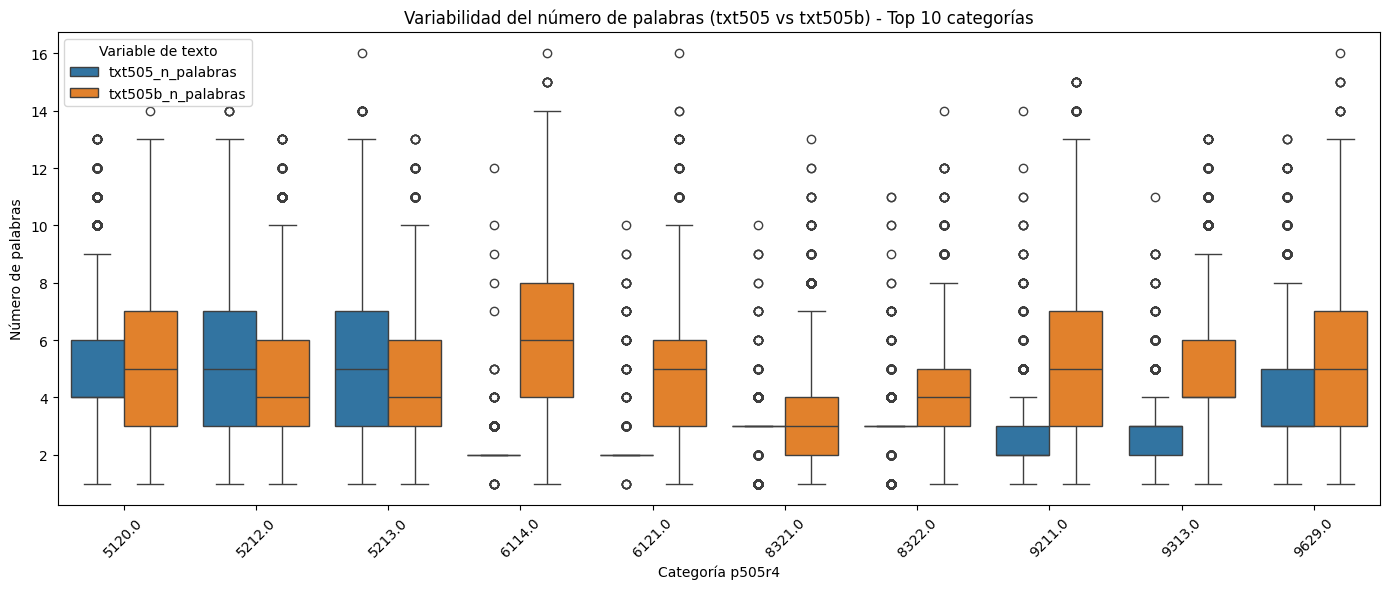

In [ ]:
# Distribución de numero de palabras
plt.figure(figsize=(14,6))
sns.boxplot(
    data=pd.melt(
        df_top10,
        id_vars='p505r4',
        value_vars=['txt505_n_palabras', 'txt505b_n_palabras'],
        var_name='Variable',
        value_name='N_palabras'
    ),
    x='p505r4', y='N_palabras', hue='Variable'
)
plt.xticks(rotation=45)
plt.title('Variabilidad del número de palabras (txt505 vs txt505b) - Top 10 categorías')
plt.xlabel('Categoría p505r4')
plt.ylabel('Número de palabras')
plt.legend(title='Variable de texto')
plt.tight_layout()
plt.show()

- En el caso de ocupación, los promedios de palabras más bajos se observan en las categorías 6114, 6121, 8321 y 8322.

- En cuanto a tareas, se aprecia un comportamiento similar entre estas categorías, con un promedio cercano a 5 palabras por registro.


# 3. Resumen

txt505

- Corregir palabras mal escritas.
- Corregir literales que contengan números.
- Normalizar el uso de tildes (ej. logística / logistica).
- Eliminar palabras sin significado (stopwords) para el modelo Bag of Words.
- Reducir las palabras a su raíz (lemmatization o stemming) para Bag of Words.

txt505b

- Tratar valores perdidos (Imputar)
- Corregir palabras mal escritas.
- Corregir literales que contengan números.
- Normalizar el uso de tildes (ej. logística / logistica).
- Eliminar palabras sin significado (stopwords) para el modelo Bag of Words.
- Reducir las palabras a su raíz (lemmatization o stemming) para Bag of Words.

p505r4

- Transformar a variable categórica.
- Corregir la codificación a cuatro dígitos agregando ceros a la izquierda cuando sea necesario.

p506r4

- Transformar a variable categórica.
- Corregir la codificación a cuatro dígitos agregando ceros a la izquierda cuando sea necesario.

p207 : Sexo

- Ninguno.

p208a : Edad

- Ninguno.

p301a : Grado de estudios

- Tratar valores perdidos (imputar)

p507 : Posición ocupacional

- Ninguno.

p510 : Organización para la que labora

- Tratar valores perdidos (imputar)

p301a1: Carrera superior (universitaria o no universitaria)

- Tratar valores perdidos (imputar)